In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [2]:
data_dir = 'facenet_pytorch/data/CustomTrain'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [5]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [38]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

Batch 10 of 16

M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_boxes = np.array(selected_boxes)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:446: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_points = np.array(selected_points)


Batch 16 of 16

In [39]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [40]:
resnet.load_state_dict(torch.load('CustomTrained_StateDict.pth'))

<All keys matched successfully>

# Inference

In [41]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/val')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [42]:
dataset.idx_to_class

{0: 'Ishan',
 1: 'Janvi',
 2: 'Rahul',
 3: 'Rushiraj',
 4: 'Shakti',
 5: 'Tirthraj',
 6: 'Vaishvi',
 7: 'Vidhi'}

In [43]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [44]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999442
Face detected with probability: 0.998941
Face detected with probability: 0.999992
Face detected with probability: 1.000000
Face detected with probability: 0.999982
Face detected with probability: 0.999572
Face detected with probability: 0.999247
Face detected with probability: 0.999961
Face detected with probability: 1.000000
Face detected with probability: 0.999888
Face detected with probability: 0.999994
Face detected with probability: 0.999991
Face detected with probability: 0.999574
Face detected with probability: 0.999972
Face detected with probability: 0.999998


In [45]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()
print([dataset.idx_to_class[p] for p in preds])

['Ishan', 'Ishan', 'Janvi', 'Janvi', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vidhi', 'Vidhi']


# Single Image

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("facenet_pytorch/data/val/Rushiraj/rFile586.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [ ]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

In [ ]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

# Imprint Noise Matrix on Glasses

In [6]:
noise_matrix = torch.load('NoiseMatrix.pth')
noise_matrix=noise_matrix.squeeze(0)
noise_matrix.shape

torch.Size([3, 160, 160])

In [ ]:
x = noise_matrix.resize_([3, 40, 40])
x.shape

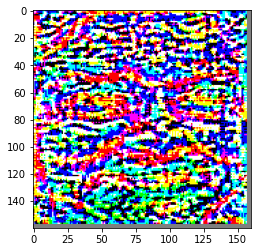

In [7]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(noise_matrix.detach().cpu(), padding=2, normalize=True),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


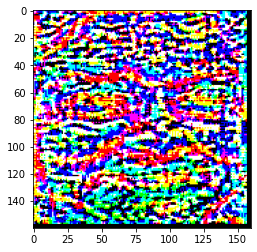

In [11]:
np_img = noise_matrix.detach().cpu().numpy()
print(type(np_img))
np_img.shape

np_img = np.transpose(np_img, (1,2,0))
plt.imshow(np_img)

# BD on Face

In [10]:
import cv2
import numpy as np
import dlib
from math import hypot

# Load the camera and Band Aid Image and create a mask
bd_image = cv2.imread("M:/AdversarialAttacks/effect_1/BD.jpeg")
frame = cv2.imread("M:/AdversarialAttacks/effect_1/rushi.jpg")
rows, cols, _ = frame.shape
nose_mask = np.zeros((rows, cols), np.uint8)

# Loading the Face Detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("M:/AdversarialAttacks/effect_1/shape_predictor_68_face_landmarks.dat")



nose_mask.fill(0)
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faces = detector(frame)
for face in faces:
    landmarks = predictor(gray_frame, face)

    # Nose coordinates
    top_nose = (landmarks.part(27).x, landmarks.part(27).y)
    center_nose = (landmarks.part(29).x, landmarks.part(29).y)

    left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
    right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

    nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                            left_eye_point[1] - right_eye_point[1]))

    nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

    # New nose position
    top_left = (int(center_nose[0] - nose_width / 2),
                    int(center_nose[1] - nose_height /2))

    bottom_right = (int(center_nose[0] + nose_width / 2),
                        int(center_nose[1] + nose_height / 2))

    # Adding the Band Aid Image
    bd_pic = cv2.resize(bd_image, (nose_width, nose_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    nose_area = frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width]

    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)

    final_nose = cv2.add(nose_area_no_nose, bd_pic)

    frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width] = final_nose

    #cv2.imshow("Final Nose", final_nose)

print(frame.shape)
#cv2.imshow("Frame", frame)
cv2.imwrite("Nose.png", frame)
#key = cv2.waitKey(0)




(112, 112, 3)


True

In [12]:
bd_image = cv2.imread("M:/AdversarialAttacks/effect_1/BD.jpeg")
type(bd_image)

numpy.ndarray

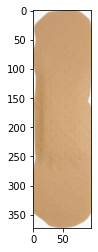

In [25]:
bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)
plt.imshow(bd_image)

In [15]:
np_img = cv2.resize(np_img, (bd_image.shape[1], bd_image.shape[0]))
np_img.shape

(373, 100, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


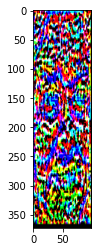

In [29]:
np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

plt.imshow(np_img)

In [30]:
test = bd_image + bd_image*np_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


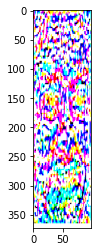

In [32]:
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

plt.imshow(test)

In [35]:
cv2.imwrite("NoisyPatch.png", test)

True

# Placing Noisy Patch on Face

In [ ]:
import cv2
import numpy as np
import dlib
from math import hypot

# Load the camera and Band Aid Image and create a mask
bd_image = cv2.imread("NoisyPatch.png")
frame = cv2.imread("M:/AdversarialAttacks/effect_1/rushi.jpg")
rows, cols, _ = frame.shape
nose_mask = np.zeros((rows, cols), np.uint8)

# Loading the Face Detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("M:/AdversarialAttacks/effect_1/shape_predictor_68_face_landmarks.dat")



nose_mask.fill(0)
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faces = detector(frame)
for face in faces:
    landmarks = predictor(gray_frame, face)

    # Nose coordinates
    top_nose = (landmarks.part(27).x, landmarks.part(27).y)
    center_nose = (landmarks.part(29).x, landmarks.part(29).y)

    left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
    right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

    nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                            left_eye_point[1] - right_eye_point[1]))

    nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

    # New nose position
    top_left = (int(center_nose[0] - nose_width / 2),
                    int(center_nose[1] - nose_height /2))

    bottom_right = (int(center_nose[0] + nose_width / 2),
                        int(center_nose[1] + nose_height / 2))

    # Adding the Band Aid Image
    bd_pic = cv2.resize(bd_image, (nose_width, nose_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    nose_area = frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width]

    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)

    final_nose = cv2.add(nose_area_no_nose, bd_pic)

    frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width] = final_nose

    #cv2.imshow("Final Nose", final_nose)

print(frame.shape)
#cv2.imshow("Frame", frame)
cv2.imwrite("FinalNoisyImage.png", frame)
#key = cv2.waitKey(0)




# Noisy Patch Inference

In [46]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("FinalNoisyImage.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [47]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

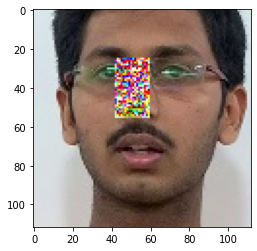

In [50]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(transformed_image.detach().cpu(), padding=2, normalize=False),(1,2,0)))

In [51]:
resnet.eval()

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([6.2989], device='cuda:0', grad_fn=<MaxBackward0>) [0]
['Ishan']


# Normal Image Inference

In [52]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("M:/AdversarialAttacks/effect_1/rushi.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [53]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

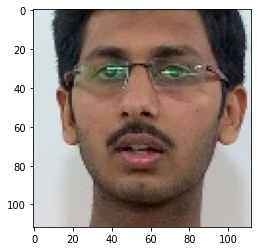

In [54]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(transformed_image.detach().cpu(), padding=2, normalize=False),(1,2,0)))

In [55]:
resnet.eval()

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([15.2661], device='cuda:0', grad_fn=<MaxBackward0>) [3]
['Rushiraj']
